In [115]:
import numpy as np
import operator

In [116]:
## 创建数据集合
def createDataSet():
    group = array([[1.0,1.1],[1.0,1.0],[0,0],[0,0.1]])
    labels = ['A','A','B','B']
    return group, labels

group,labels=createDataSet()

## k近邻算法
def classify1(inX, dataSet, labels, k):   
    '''k近邻算法'''
    ds=np.array(dataSet)
    x=np.array(inX)    
    sorts=((ds-x)**2).sum(axis=1).argsort()
    counts={}
    for i in range(k):
        voteLabel=labels[sorts[i]]
        counts[voteLabel]=counts.get(voteLabel,0)+1
    s=sorted(counts.items(),key=operator.itemgetter(1),reverse=True)
    return s[0][0]

print(classify1([0,0], group,labels,3))

B


In [117]:
def file2matrix(filename):
    fr=open(filename)
    arrayOLines=fr.readlines()
    numberofline=len(arrayOLines)
    #想要的矩阵
    returnMat = np.zeros((numberofline,3))
    
    classLabel=[]
    index=0
    for line in arrayOLines:
        lists = line.strip().split('\t')
        returnMat[index,:]=lists[0:3]
        classLabel.append(int(lists[-1]))
        index += 1
        
    return returnMat,classLabel

dataset,classLabel=file2matrix('datingTestSet2.txt')
dataset[0]

array([4.092000e+04, 8.326976e+00, 9.539520e-01])

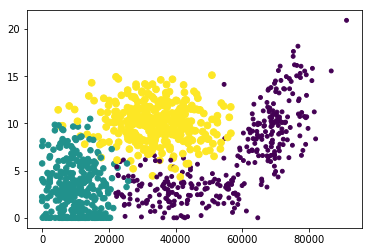

In [118]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

plt.scatter( dataset[:,0],dataset[:,1],15.0*array(classLabel),15.0*array(classLabel))
#看起来分布挺好

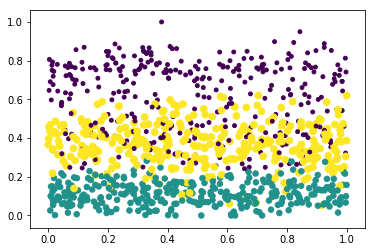

In [119]:
def autoNorm(dataSet):
    '''
    normalize，线性归一
    '''
    minv=dataSet.min(0)
    maxv=dataSet.max(0)
    ranges= maxv-minv
    normalSet=zeros(shape(dataSet))
    
    m=dataSet.shape[0]
    normalSet = dataSet - tile( minv, (m,1))
    normalSet = normalSet / tile( ranges, (m,1))
    
    return normalSet, ranges,minv

normalMat, ranges, minv=autoNorm(dataset)
plt.scatter( normalMat[:,2],normalMat[:,0],15.0*array(classLabel),15.0*array(classLabel))

In [125]:
def autoNorm2(dataSet):
    '''
    分布
    '''
    m=dataSet.mean(0)
    v=dataSet.var(0)   
    return (dataSet-m)/v,-1,-1

ds2,a,b=autoNorm2(dataset)
# plt.scatter( ds2[:,1],nn[:,0],15.0*array(classLabel),15.0*array(classLabel))
#这个看起来效果不好，容易受异常值影响

In [121]:
def datingClassTest(hoRation,k):
    '''
    hoRation 取值数据的比例
    '''
    datingMat,datingLabels=file2matrix('datingTestSet2.txt') #read data
    normalMat,ranges,minv=autoNorm(datingMat)
    m=normalMat.shape[0]
    numTestVecs=int(m*hoRation)
    errorCount=0
    
    for i in range(numTestVecs):
        classifyResult=classify1(normalMat[i,:],normalMat[numTestVecs:m,:],\
                                datingLabels[numTestVecs:m],k)  
        if classifyResult != datingLabels[i]:
            errorCount+=1
    
    print('error ', errorCount/numTestVecs,errorCount,numTestVecs)
    
datingClassTest(0.8,6)
## 采用平均值归一：0.455 364 800
## 采用区间映射：  0.065 52 800

error  0.065 52 800


In [124]:
##
import os
def readVec(dirs):
    datas=[]
    labels=[]
    names = os.listdir(dirs)
    for name in names:
        
        lines=open(dirs+name)
        tmpdata=[]
        for line in lines:
            for c in line.strip():
                tmpdata.append(int(c))
    
        label=int(name.split('_')[0])
        
        datas.append(tmpdata)
        labels.append(label)
    
    return np.array(datas),np.array(labels)

        
trainData,trainLabel=readVec('./trainingDigits/')
testData,testLabel=readVec('./testDigits/')

errors=0
for i in range(len(testData)):
    classifyResult=classify1(testData[i,:],trainData,
                                trainLabel,4)
    if classifyResult != testLabel[i]:
        errors+=1
    
print( errors/len(testData))
# 3 0.010570824524312896
# 4 0.011627906976744186

0.011627906976744186


平衡$kd$树构建算法：
- 输入：$k$维空间样本集$\mathbb{D}=\{\vec x_1,\vec x_2,\dots,\vec x_N\} , \vec x_i \in \chi \subseteq \mathbb{R}^n$
- 输出：$kd$树
- 算法步骤：
    - 构造根结点。根结点对应于包含$\mathbb{D}$的$k$维超矩形。
    选择$x_1$为轴，以$\mathbb{D}$中所有样本的$x_1$坐标的中位数$x_1^*$为切分点，将根结点的超矩形切分为两个子区域，切分产生深度为$1$的左、右子结点。切分超平面为$x_1=x_1^*$：
        - 左子节点对应$x_1<x_1^*$子区域
        - 右子节点对应$x_1>x_1^*$子区域
        - 在切分超平面的点$x_1=x_1^*$保存在根节点。
    - 对深度为$j$的节点，选择$x_l$为切分的坐标轴继续切分，$l=j(mod k) + 1$.本次切分之后，树深度$l+1$.
    - 直到所有节点的两个子域没有样本位置。

In [158]:
#kd
class KdtreeNode:
    def __init__(self,layer,dimmension,val,left=None,right=None):
        self.layer=layer
        self.val=val
        self.left=left
        self.right=right
        self.dimmension=dimmension

def constructTree(datas,layer_now):
    if len(datas) == 0 : return None
    k = len(datas[0])
    true_dimmension=layer_now%k
    
    median=np.median(datas,axis=0)
    me=median[true_dimmension]    
    node=KdtreeNode(layer_now,true_dimmension,median)
    leftData=datas[datas[:,true_dimmension]<me].copy()
    rightData=datas[datas[:,true_dimmension]>me].copy()
    node.left = constructTree(leftData,layer_now+1)
    node.right = constructTree(rightData,layer_now+1)
    
    return node

def traverse(node):
    if node == None: return
    print(node.layer,node.dimmension,node.val, node.left,node.right)
    traverse(node.left)
    traverse(node.right)
    
def found(node, v):
    pass
    

In [160]:
datas=np.random.randint(1,10,(6,2))
print(datas)
np.median(datas,axis=0)
node=constructTree(datas,1)
traverse(node)

[[2 6]
 [7 6]
 [6 8]
 [3 8]
 [9 6]
 [3 5]]
1 1 [4.5 6. ] <__main__.KdtreeNode object at 0x0000022EB33D9A90> <__main__.KdtreeNode object at 0x0000022EB33D98D0>
2 0 [3. 5.] None None
2 0 [4.5 8. ] <__main__.KdtreeNode object at 0x0000022EB33D9E80> <__main__.KdtreeNode object at 0x0000022EB33D9C50>
3 1 [3. 8.] None None
3 1 [6. 8.] None None
